#**Nupur Yadav [ID: 013931411]**

## I have chosen an already implemented factor but mine approach is completely different from what has been provided in the shared colab. The approach has been mentioned few steps below. I have used 2 other datasets than liar liar for data enrichment unlike shared colab. Also, I have performed LDA on all three datasets as part of distillation and used Doc2Vec model (for generating statement word embeddings which are directly used as features), Neural network (for predicting a vector, which comprises the probability scores for each party affliation)and multiclass classification models (for making final multiclass prediction between 1-6) to model my factor for predicting fakeness.

# **Political Affiliation Factor**

**Political Affiliation** means closeness to or supporting a particular political party.

It is a very important factor in determining if a news or statement is fake because party members usually stick to the party's philosophy and any digression from that is a good approximator of fakenews. So, I have tried to model this factor to check the credibility of news.

# **Data Enrichment**

For the purpose of data enrichment I have used **Kaggle Fake News dataset** and **Politifact News dataset** which had similar domain data to that of liar liar dataset (comprises mainly of political topics)

[Link to Kaggle Fake News Dataset](https://www.kaggle.com/mrisdal/fake-news)

[Info about Politifact News Dataset](https://www.uvic.ca/engineering/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf)

[Link to Politifact News Dataset](https://drive.google.com/file/d/1IoTRrJNDJqvaG3hnUpnHQyGvPAJbO8y3/view)


# **Important python libraries used**



1.   NLTK
2.   gensim
3.   fastai



# **General Approach**

1. Get data from liar dataset, kaggle fakenews dataset and politifact news dataset.
2. Initial data exploration
3. Remove unwanted columns
4. Clean the datasets using standard NLP practices such as stop word removal, lemmitization, stemming, removing puncuations etc.
5. Update the Party affiliation of liar dataset to include only three types to handle class imbalance in party affiliation labels
    *  Democrat
    *  Republican
    *  No-affiliation and Other as Other
    
6. Create corpus of text by combining both the datasets
7. Create Doc2Vec embeddings (length = 10) using genism for each tagged document
8. Feature Engineering : Use the generated doc2vec embeddings directly as features alongwith other categorical features such as state_info, speaker_job_title, context
9. Train a neural network on the above features which is using softmax and predicting a vector, which comprises the probability scores for each party affliation.
10. Use the probability scores generated to train several multiclass classification models (such as Logistic Regression, DecisionTreeClassifier, GaussianNB, XGBClassifier, RandomForestClassifier, SVC and KNeighborsClassifier) **to predict the fakeness of the given statement between 1-6 with 1 being true and 6 being pants-fire.**

# **Importing necessary libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from nltk.stem.porter import *
from sklearn import metrics
import pickle
from fastai import *
from fastai.tabular import *


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(1)

In [0]:
# Read data file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# **Loading Liar dataset**

In [0]:
#Defining link to the liar dataset
link = 'https://drive.google.com/open?id=1Gw5NhXqsnWJnQURLkjnvhcmk5ExTB89X'
fluff, id = link.split('=')

#downloading the zip file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar_dataset.zip')

import zipfile
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:

    zip_ref.extractall()

liar_train = pd.read_csv('train.tsv', sep='\t',header=None)
liar_train=liar_train.drop(columns=[0])

liar_test = pd.read_csv('test.tsv', sep='\t',header=None)
liar_test=liar_test.drop(columns=[0])


In [0]:
columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state_info',
'affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar_train.columns=columns
liar_test.columns=columns

In [6]:
#Combining train and test datasets
liar=pd.concat([liar_train,liar_test])
liar.head(2)


,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


## **Cleaning Liar dataset**

Cleaning the dataset includes: 
Stopwords removal, stemming, lemmatization, converting to lowercase, removing punctuations, special characters and digits, and word tokenization

In [7]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanStatement

liar.dropna()
liar['CleanStatement'] = liar['statement'].map(lambda x: re.sub(r"\W", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r" \d+", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: word_tokenize(x.lower()))

liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: ' '.join(x))
liar['CleanStatement'] = liar['CleanStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

liar.head(2)

,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,CleanStatement
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,says annies list political group supports third trimester abortions demand
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start started natural gas took started begin president george w bushs administration


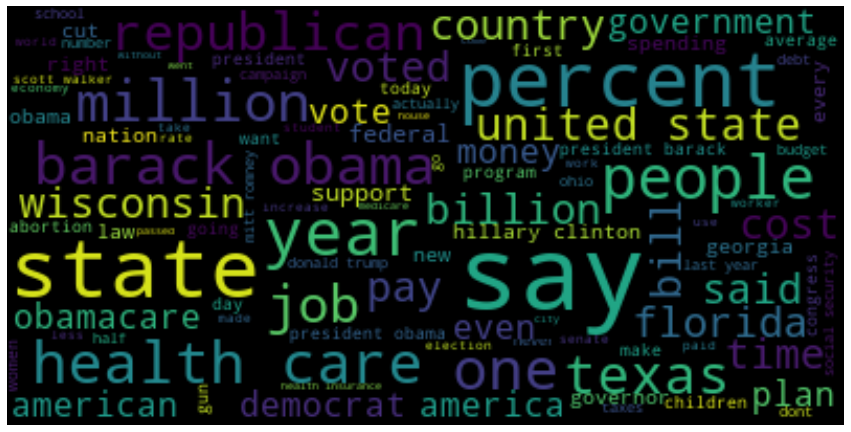

In [8]:
#Displaying wordcloud for Liar dataset
text= ' '.join(liar.CleanStatement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

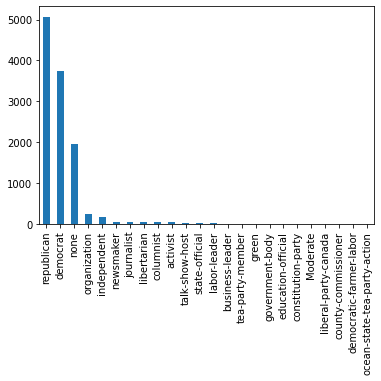

In [9]:
#looking at the distribution of party affiliation in the liar dataset
liar.affiliation.value_counts().plot(kind='bar')

As we can see in above plot most of the records belongs to only republican and democrat affiliation so in order to handle this class imbalance I have considered only 3 categories: republican, democrat and rest as other.

In [0]:
def combine_party_affiliation_type(input_label):
    if input_label == 'democrat':
      return str('democrat')
    elif input_label == 'republican':
      return str('republican')
    else:
      return str('other')

liar['affiliation'] = liar.apply(lambda row: combine_party_affiliation_type(row['affiliation']), axis=1)

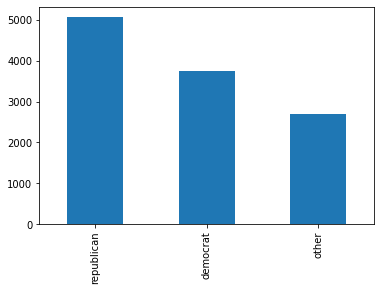

In [11]:
liar.affiliation.value_counts().plot(kind='bar')

The above plot shows the party affiliation labels after handling class imbalance.

In [0]:
# liar = liar[liar['affiliation']!='other']

## **Performing LDA on liar liar dataset**

As part of distillation performing LDA on liar liar dataset and generating 10 topics with the LDA model

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(liar['CleanStatement'])

In [14]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
says time people house texas scott education get first walker

Topic #1:
obama president barack says bush obamas border john said immigration

Topic #2:
year billion years states percent million budget spending says united

Topic #3:
says rate million romney percent mitt unemployment people years every

Topic #4:
tax says percent taxes state pay would income voted cuts

Topic #5:
jobs says state created security since job new social percent

Topic #6:
health care says insurance law trump would donald obamacare state

Topic #7:
says clinton hillary one campaign bill said senate voting law

Topic #8:
percent states rhode state people island says year federal country

Topic #9:
says new rick scott city court texas gov york states


Displaying Top 10 Common Words

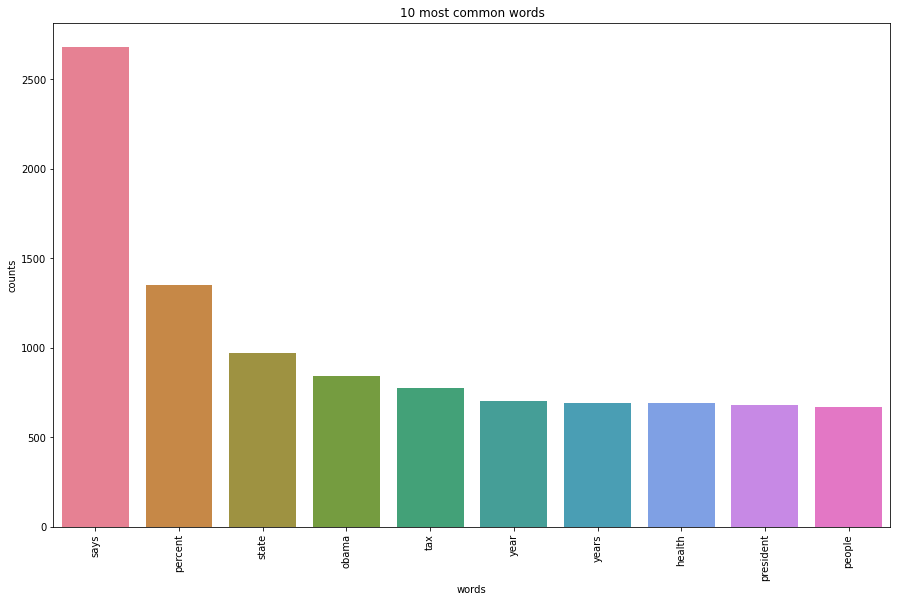

In [15]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# **Loading Kaggle fake news dataset**

In [0]:
link = 'https://drive.google.com/open?id=12UVATQQ5LJCXqYUm7JySfTJ_HvrJzcCq'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fake.csv')

fake_df = pd.read_csv('fake.csv')
fake_df=fake_df.drop(columns=['uuid','ord_in_thread', 'author', 'published',  'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score'	,'main_img_url', 'replies_count', 'participants_count',	'likes',	'comments',	'shares',	'type' ])
fake_df=fake_df.drop_duplicates()

#dropping all the records where title is NaN
fake_df. dropna(subset = ['title'], inplace=True)

In [17]:
fake_df.head(2)

,title,text
0,Muslims BUSTED: They Stole Millions In Gov’t Benefits,Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related
1,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,"Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can’t recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! \n100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran…Corrupt to the core! Attorney General Loretta Lynch is declining to comply with an investigation by leading members of Congress about the Obama administration’s secret efforts to send Iran $1.7 billion in cash earlier this year, prompting accusations that Lynch has “pleaded the Fifth” Amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the Washington Free Beacon. \nSen. Marco Rubio (R., Fla.) and Rep. Mike Pompeo (R., Kan.) initially presented Lynch in October with a series of questions about how the cash payment to Iran was approved and delivered. \nIn an Oct. 24 response, Assistant Attorney General Peter Kadzik responded on Lynch’s behalf, refusing to answer the questions and informing the lawmakers that they are barred from publicly disclosing any details about the cash payment, which was bound up in a ransom deal aimed at freeing several American hostages from Iran. \nThe response from the attorney general’s office is “unacceptable” and provides evidence that Lynch has chosen to “essentially plead the fifth and refuse to respond to inquiries regarding [her]role in providing cash to the world’s foremost state sponsor of terrorism,” Rubio and Pompeo wrote on Friday in a follow-up letter to Lynch. More Related"


## **Cleaning Kaggle fake news data**

Cleaning the dataset includes: Stopwords removal, stemming, lemmatization, converting to lowercase, removing punctuations, special characters and digits, and word tokenization

In [0]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanTitle and CleanText

fake_df['CleanTitle'] = fake_df['title'].map(lambda x: re.sub(r"\W", " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: re.sub(r" \d+", " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: word_tokenize(x.lower()))

fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: ' '.join(x))
fake_df['CleanTitle'] = fake_df['CleanTitle'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [19]:
fake_df.head(2)

,title,text,CleanTitle
0,Muslims BUSTED: They Stole Millions In Gov’t Benefits,Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related,muslims busted stole millions gov benefits
1,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,"Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can’t recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! \n100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran…Corrupt to the core! Attorney General Loretta Lynch is declining to comply with an investigation by leading members of Congress about the Obama administration’s secret efforts to send Iran $1.7 billion in cash earlier this year, prompting accusations that Lynch has “pleaded the Fifth” Amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the Washington Free Beacon. \nSen. Marco Rubio (R., Fla.) and Rep. Mike Pompeo (R., Kan.) initially presented Lynch in October with a series of questions about how the cash payment to Iran was approved and delivered. \nIn an Oct. 24 response, Assistant Attorney General Peter Kadzik responded on Lynch’s behalf, refusing to answer the questions and informing the lawmakers that they are barred from publicly disclosing any details about the cash payment, which was bound up in a ransom deal aimed at freeing several American hostages from Iran. \nThe response from the attorney general’s office is “unacceptable” and provides evidence that Lynch has chosen to “essentially plead the fifth and refuse to respond to inquiries regarding [her]role in providing cash to the world’s foremost state sponsor of terrorism,” Rubio and Pompeo wrote on Friday in a follow-up letter to Lynch. More Related",attorney general loretta lynch plead fifth


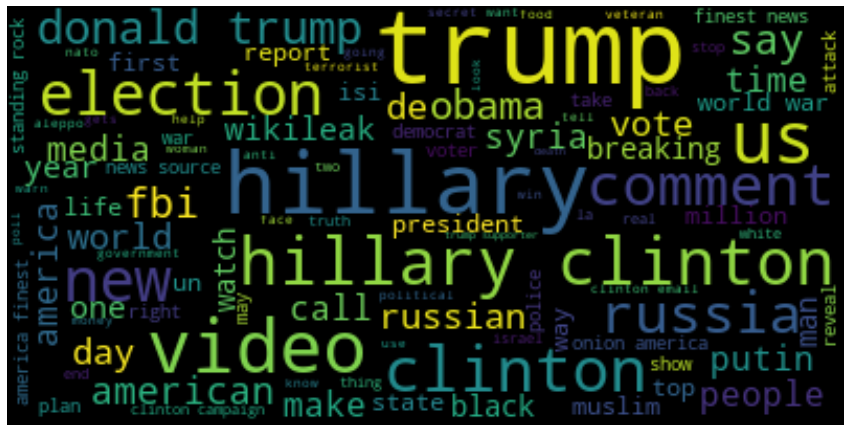

In [20]:
#Displaying wordcloud for Kaggle fake news dataset
text= ' '.join(fake_df.CleanTitle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Performing LDA on Kaggle fake news dataset** 

As part of distillation performing LDA on kaggle fake news dataset and generating 10 topics with the LDA model

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(fake_df['CleanTitle'])

In [22]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
election hillary us comment news daily day breaking voting obama

Topic #1:
clinton hillary fbi emails investigation email wikileaks de campaign new

Topic #2:
obama election get us say video open day find hillary

Topic #3:
trump clinton hillary america news source video onion finest voter

Topic #4:
trump donald hillary video clinton president new media obama victory

Topic #5:
trump us hillary comment clinton putin change russia la de

Topic #6:
war russia us russian syria aleppo world syrian mosul nato

Topic #7:
police rock standing pipeline dakota comment access protesters russia trump

Topic #8:
hillary trump clinton vote america putin russia news october election

Topic #9:
new trump election comey people video comment elections american things


Displaying Top 10 Common Words

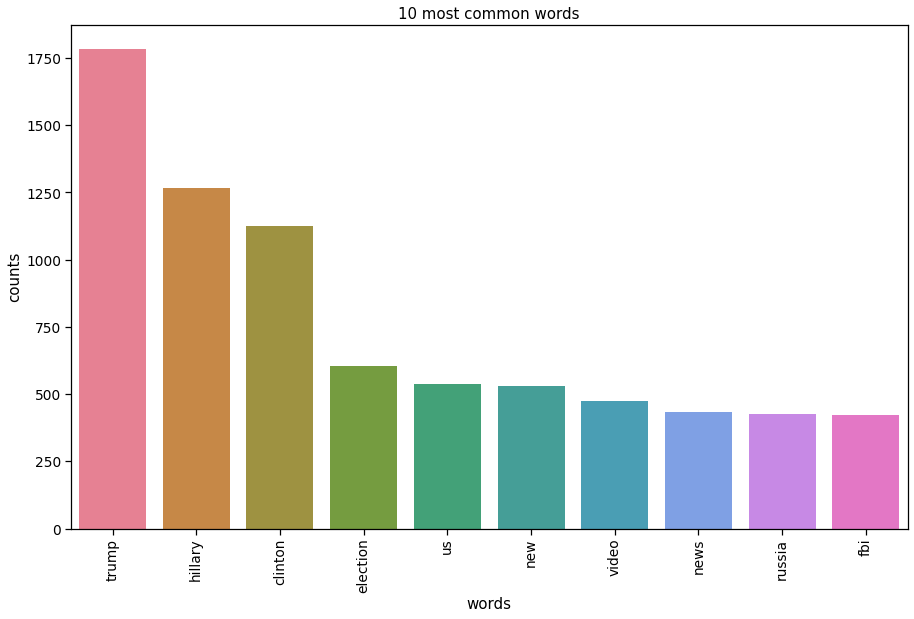

In [23]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# **Loading Politifact News dataset**

In [24]:
#Defining link to the Politifact dataset
link = 'https://drive.google.com/open?id=1av4nS7rDXf387za7cOibO-qtxOhXenOR'
fluff, id = link.split('=')

#downloading the zip file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('News_dataset.zip')

import zipfile
with zipfile.ZipFile('News_dataset.zip', 'r') as zip_ref:

    zip_ref.extractall()

politifact_fake = pd.read_csv("Fake.csv",sep=',')
politifact_true = pd.read_csv("True.csv",sep=',')
df_politifact = pd.concat([politifact_fake, politifact_true])
df_politifact = df_politifact.drop(columns=['text', 'subject', 'date'])
df_politifact.head()

,title
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech


## **Cleaning Politifact news dataset**

Cleaning the dataset includes: Stopwords removal, stemming, lemmatization, converting to lowercase, removing punctuations, special characters and digits, and word tokenization

In [0]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanTitle and CleanText

df_politifact['CleanTitle'] = df_politifact['title'].map(lambda x: re.sub(r"\W", " ",str(x)))
df_politifact['CleanTitle'] = df_politifact['CleanTitle'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
df_politifact['CleanTitle'] = df_politifact['CleanTitle'].map(lambda x: re.sub(r" \d+", " ",str(x)))
df_politifact['CleanTitle'] = df_politifact['CleanTitle'].map(lambda x: word_tokenize(x.lower()))

df_politifact['CleanTitle'] = df_politifact['CleanTitle'].map(lambda x: ' '.join(x))
df_politifact['CleanTitle'] = df_politifact['CleanTitle'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [26]:
df_politifact.head()

,title,CleanTitle
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,donald trump sends embarrassing new year eve message disturbing
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,drunk bragging trump staffer started russian collusion investigation
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,sheriff david clarke becomes internet joke threatening poke people eye
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),trump obsessed even obama name coded website images
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,pope francis called donald trump christmas speech


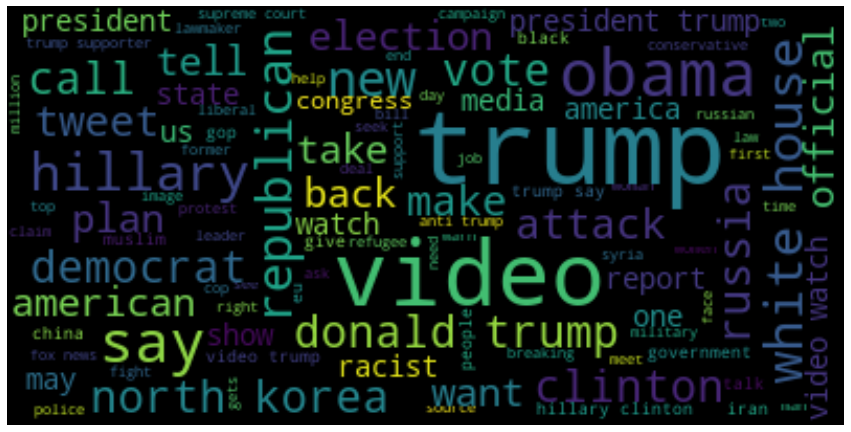

In [27]:
#Displaying wordcloud for Kaggle fake news dataset
text= ' '.join(df_politifact.CleanTitle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Performing LDA on Politifact news dataset** 

As part of distillation performing LDA on politifact news dataset and generating 10 topics with the LDA model

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_politifact['CleanTitle'])

In [29]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
state says trump syria islamic military syrian china attack air

Topic #1:
trump new says governor election law republican party calls iran

Topic #2:
trump korea north says russia putin twitter china nuclear paul

Topic #3:
says minister court foreign room saudi police leader vote boiler

Topic #4:
trump obama house white video news donald fox court president

Topic #5:
says tax deal bill senate eu brexit may trump republican

Topic #6:
trump video watch hillary gets cnn president donald sanders clinton

Topic #7:
video hillary obama black trump clinton breaking america watch new

Topic #8:
video bill trump clinton school gun president puerto rico gop

Topic #9:
trump new says probe russia calls general senator former attorney


Displaying Top 10 Common Words

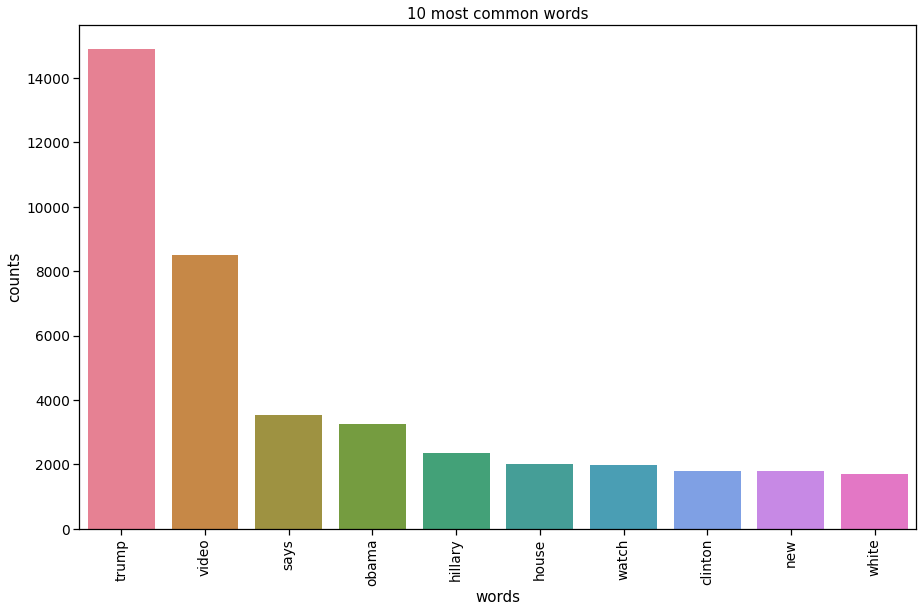

In [30]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

**As we can see above, performing LDA as part of distillation on all the three datasets gave us an insight of the topics they contain which mainly comprises of trump, hillary, clinton, elections , US that is around political stuff. But LDA didn't help in generating any useful features for modeling my political affiliation factor. So, I am combining text in all the three datasets into a single corpus to create doc2vec embeddings using this enriched data.**

# **Combining text in all three datasets to create a doc2vec model**

In [0]:
data = []
data = liar.CleanStatement.tolist() + fake_df.CleanTitle.tolist() + df_politifact.CleanTitle.tolist()

In [32]:
#Generating tagged documents for training doc2vec model
tagged_data = []
exception_count = 0
for index, text in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(text.lower()), tags=[str(index)]))
    except:
        exception_count+=1

tagged_data[0]


TaggedDocument(words=['says', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'demand'], tags=['0'])

# **Train Doc2Vec Model**

In [33]:
#Initializing hyperparameters for doc2vec model
max_iterations = 8
vector_size = 10
alpha = 0.025

d2v_model = Doc2Vec(size=vector_size, alpha=alpha, min_alpha=0.00025, min_count=10, dm =1)

#Building the vocabulary  
d2v_model.build_vocab(tagged_data)

#training model with decreasing learning rate at every iteration
for i in range(max_iterations):
    print('Iteration: {0}'.format(i))
    d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.iter)
    d2v_model.alpha -= 0.0002
    d2v_model.min_alpha = d2v_model.alpha


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [34]:
#Saving the model
import pickle
filename = 'doc2vec1_model.sav'
pickle.dump(d2v_model, open(filename, 'wb'))
d2v_model.save("doc2vec1.model")
print("Doc2Vec Model Saved")

Doc2Vec Model Saved


In [35]:
#Checking the embeddings generated by doc2vec model for a given text sample
text = "decline coal start started natural gas took started begin president george w bushs administration"
d2vmodel= Doc2Vec.load("doc2vec1.model")
test_ex= [d2vmodel.infer_vector(word_tokenize(text))]
print(test_ex)

[array([-0.053854, -0.033429,  0.010693, -0.054255, -0.536815,  0.231185, -0.087829, -0.3192  , -0.03872 , -0.276847],
      dtype=float32)]


# **Creating Training dataset for Neural Network**

Training a neural network on the doc2vec embeddings generated for statement feature and other categorical features from liar dataset such as state, job_title and context to generate a probability vector which gives the probability scores for each party affiliation. 

Neural network is using softmax at the output layer to generate these probability scores and make the prediction for party affiliation as the one with the highest probability.

In [0]:
#Generating word embeddings for cleanstatement in liar dataset using previously trained Doc2Vec model
statement_wordvec = []
for statement in liar.CleanStatement.tolist():
    statement_wordvec.append(d2vmodel.infer_vector(word_tokenize(statement)))

In [0]:
#Defining training data for Neural Network
df = pd.DataFrame(statement_wordvec)
df['speaker_job_title']= liar.speaker_job_title.tolist()
df['state_info'] = liar.state_info.tolist()
df['context'] = liar.context.tolist()
df['party_affiliation'] = liar.affiliation.tolist()

df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

In [38]:
#Displaying training data for Neural network
df.tail(5)

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker_job_title,state_info,context,party_affiliation
11502,0.154966,-0.592689,-0.049297,-0.189870,-0.438509,0.177001,0.075078,-0.296139,0.095435,-0.130605,Governor,Florida,a news conference,republican
11503,0.242197,-0.212872,0.074302,-0.036762,-0.317464,0.072108,-0.019626,-0.159791,0.190162,-0.108817,Governor,Missouri,"on ABC's ""This Week""",democrat
11504,0.396801,0.071585,0.195140,-0.311175,0.344667,0.237079,-0.290709,0.032767,-0.414058,0.262231,"senior fellow, Foreign Policy Research Institute",Rhode Island,a commentary in The Providence Journal,other
11505,0.142549,0.040764,-0.348083,0.025840,-0.001321,0.070358,-0.163934,-0.125457,0.007352,0.161978,"Governor of Ohio as of Jan. 10, 2011",Ohio,a news conference,republican
11506,-0.002379,-0.647418,-0.092588,-0.115541,-0.486567,0.094530,-0.018176,-0.094883,0.174764,-0.028121,NaN,NaN,an interview with NJToday,democrat


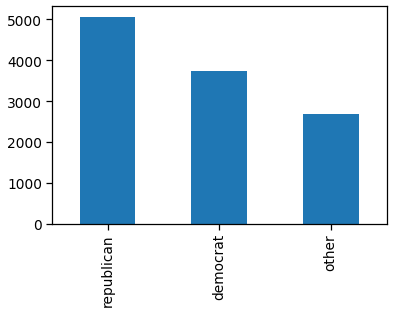

In [39]:
#Displaying party affiliation dustribution across the training dataset
df.party_affiliation.value_counts().plot(kind='bar')#(10)

# **Building the Neural Network model**

In [40]:
#Splitting dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=1)

len(train_df), len(test_df)

(9780, 1727)

In [0]:
# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

In [0]:
# Preparing categorical and continous data columns for building Tabular DataBunch.
cat_vars = ['speaker_job_title', 'state_info', 'context' ]
cont_vars = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9']

In [0]:
# Defining the dependent (target) variable
dep_var = 'party_affiliation'

In [0]:
#Specifying the valid_idx variable as the cut out range.
valid_idx = range(1727)

In [0]:
train_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']
test_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

#Preparing a test dataset
test = TabularList.from_df(test_df, path=Path(), cat_names=None, cont_names=cont_vars)

In [46]:
# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(train_df, path=Path(), cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())
data.show_batch(rows=10)

speaker_job_title,state_info,context,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,target
Ohio attorney general,Ohio,a news release,-0.8974,1.8514,-0.3356,-0.9209,-1.1476,-0.1844,1.3139,0.7056,0.3771,-0.5896,republican
U.S. Senator,Florida,a press release,-0.6432,-0.1775,0.2645,-1.0301,-0.1033,-1.6757,-0.3996,-0.4101,0.3495,0.4037,republican
U.S. Representative,Virginia,radio interview.,-0.2171,1.2729,-2.5485,1.3888,-0.7100,2.2080,-0.5837,-0.1564,-1.8884,0.4660,democrat
Radio/TV host,#na#,comments on his Fox News program,0.3943,1.3956,-1.3105,1.2871,-0.8205,-0.4818,1.4083,-0.2378,1.0593,0.7402,other
Secretary of State,Massachusetts,"comments on CBS' ""Face the Nation""",0.2686,0.5201,0.6317,-0.0195,0.3092,0.5724,-0.1014,-0.5506,1.2170,-0.1083,democrat
#na#,#na#,his column in the New York Times,0.4086,1.3260,0.0569,0.8518,0.2258,-2.0126,-0.8557,-0.1356,-0.6492,-0.9681,other
#na#,#na#,a headline on the website NewsExaminer,1.1179,-1.3420,0.1992,-0.5717,-1.0077,-2.0737,0.6516,-0.0533,0.9864,-0.1611,other
President,Illinois,a Rose Garden press conference,-0.4380,0.7614,-1.4946,-2.3949,-0.1804,-2.0547,0.6470,-0.6153,-0.3512,-0.2971,democrat
Candidate for U.S. Senate,South Dakota,a campaign ad,1.2983,0.1977,1.2002,-0.9817,-0.8731,-1.6221,-2.7842,-0.2925,1.7181,0.0358,other
Political strategist,#na#,"comments on CNN's ""State of the Union""",1.4691,-0.9018,1.3525,-2.9611,-0.4497,-0.8332,-0.9431,-0.9428,0.5007,-1.2510,democrat


In [0]:
#defining the model
learn = tabular_learner(data, layers=[30,15,3],  metrics=accuracy,emb_drop=0.2)

In [48]:
#displaying the model parameters
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1034, 78)
    (1): Embedding(76, 18)
    (2): Embedding(3582, 156)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=262, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=30, out_features=15, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=3, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [49]:
#fitting the learner and kept learning rate as le-3 because you can see in below learning rate curve the loss is minimum for this value
learn.fit_one_cycle(8,1e-2) 
#Saving the model
learn.save("NN_model")
learn.export()

epoch,train_loss,valid_loss,accuracy,time
0,0.960223,0.747086,0.696005,00:02
1,0.621147,0.544392,0.752171,00:02
2,0.450564,0.523056,0.764910,00:02
3,0.339161,0.555335,0.746960,00:02
4,0.277066,0.551481,0.752171,00:01
5,0.214848,0.550951,0.760278,00:02
6,0.192780,0.563320,0.766647,00:02
7,0.169538,0.578093,0.765489,00:01


The NN model is achieving an accuracy of `74%` approx.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


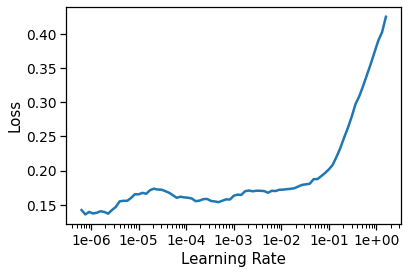

In [50]:
#Plotting the learning rate curve of the model
learn.lr_find()
learn.recorder.plot()

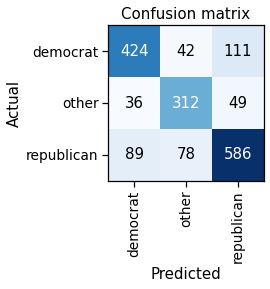

In [51]:
#Plotting the confusion matrix for the NN model
pred = ClassificationInterpretation.from_learner(learn)
pred.plot_confusion_matrix()

In [52]:
#Displaying the prediction for one of the test record
print(test_df.iloc[0],str(learn.predict(test_df.iloc[0])))

Embed_0              0.0990588                      
Embed_1             -0.233339                       
Embed_2              0.0996103                      
Embed_3             -0.152885                       
Embed_4             -0.372189                       
Embed_5             -0.0449002                      
Embed_6             -0.188427                       
Embed_7             -0.0469762                      
Embed_8              0.149602                       
Embed_9             -0.138795                       
speaker_job_title    Co-host on CNN's "Crossfire"   
state_info           Massachusetts                  
context              an episode of CNN's "Crossfire"
party_affiliation    democrat                       
Name: 7617, dtype: object (Category tensor(0), tensor(0), tensor([0.9865, 0.0019, 0.0116]))


You can see the NN model has predicted the democrat correctly as 'democrat' and have also provided us a vector denoting probaility scores towards each party affiliation. Further we will be using these scores to identify fakeness of news.

Applying the NN trained model on liar liar dataset with statement word embeddings to get predicted party and their confidence towards each party.

#**Running the trained NN model on our liar dataset to get the probability scores vector for party affiliation**

In [53]:
#Defining the data to run model on
df_final = df.drop('party_affiliation', axis=1)
df_final.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','speaker_job_title','state_info','context']
df_final.head()

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker_job_title,state_info,context
0,0.030079,-0.139814,0.199741,-0.107234,-0.215740,-0.151469,0.082046,-0.264130,0.070133,-0.084852,State representative,Texas,a mailer
1,-0.129768,0.017927,-0.014751,0.008464,-0.455862,0.238038,-0.184254,-0.369145,0.016072,-0.296974,State delegate,Virginia,a floor speech.
2,0.369158,0.017480,0.146738,-0.332058,-0.261451,0.045752,-0.053425,-0.194533,-0.003566,0.098287,President,Illinois,Denver
3,-0.054852,-0.090295,-0.240637,-0.086018,-0.447208,-0.202324,0.204578,-0.304831,0.232747,-0.044378,NaN,NaN,a news release
4,0.293764,-0.164806,0.071657,-0.167439,-0.289335,0.122000,-0.082183,-0.182603,-0.011294,-0.055507,NaN,Florida,an interview on CNN


In [0]:
#loading already trained NN model to get respective probability scores towards each individual party for every record in liar dataset
learn.load("NN_model")
probability_vector =[]
prediction =[]
for i in range(0,len(df_final)):
  pred = learn.predict(df_final.iloc[i])
  prediction.append(pred[0])
  probability_vector.append(pred[2])

In [0]:
##Converting the probailities obtained as a tensor to vectors so that it can be added to dataframe as columns
import numpy as np
prob_vector = []
for vector in probability_vector:
    v =[]
    for i in vector:
        a = float(i)
        v.append(a)
    prob_vector.append(v)

In [56]:
#Creating final training data to predict fakeness based on the probabilities towards each party affiliation
columns = ['Prob_republican','Prob_democrat', 'Prob_other', 'label']
final_df = pd.DataFrame(prob_vector)
final_df['label'] = liar.label.tolist()
final_df.columns = columns
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.111625,0.006605,0.881770,false
1,0.968378,0.000528,0.031095,half-true
2,0.999432,0.000222,0.000346,mostly-true
3,0.125879,0.612641,0.261480,false
4,0.744511,0.007865,0.247624,half-true


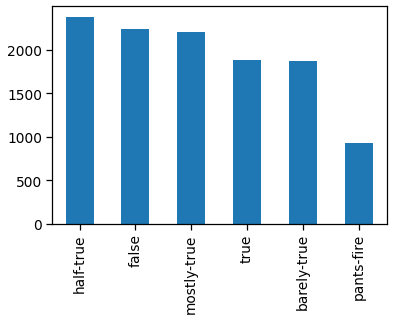

In [57]:
#looking at the distribution of fakeness class labels in the liar dataset
final_df.label.value_counts().plot(kind='bar')

# Training 7 different models (LogisticRegression, DecisionTreeClassifier, GaussianNB, XGBClassifier, RandomForestClassifier,  SVC and KNeighborsClassifier) **to predict fakeness of statement between 1-6** using the party affiliation probability scores obtained using NN model

In [0]:
#Function to run different models and print confusion matrix, accuracy score, specificity and sensitivity of models
from sklearn.metrics import plot_confusion_matrix
def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
  accuracy={}
  specificity={}
  sensitivity={}
  model_save=None
  i=0
  #models_dict holds name and its function , like {'LR':LogsticRegression()}
  for name,model in models_dict.items():
      #fitting model on the train data
      model.fit(X_train,y_train)
      #saving the model
      joblib.dump(model, name+'.pkl') 
      #predicting model on X_test 
      model_save=model
      y_pred=model.predict(X_test)
      print('*'*100)
      print('Model:',name)
      #printing Confusion matrix an dAccuracy of each model
      print("Confusion Matrix: ")
      print(confusion_matrix(y_test, y_pred))
      print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

      #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
      accuracy[name]=accuracy_score(y_test,y_pred)*100
      cm=confusion_matrix(y_test, y_pred)
      sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
      specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
      print("Classificarion Report : ")
      print(classification_report(y_test, y_pred))
      
  
  #converting dictionaries to dataframes to have them handy
  accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
  sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
  specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
  # print(accuracy)
  accuracy.columns=['model_name','accuracy']
  sensitivity.columns=['model_name','sensitivity']
  specificity.columns=['model_name','specificity']
  
  #plotting accuracy,sensitivity,specificity of each model
  plt.figure(i+1,figsize=(16, 6))
  ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
  ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
  ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
  ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
  plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ')
  return model_save

In [0]:
#Taking care of missing values in final liar dataset
final_df=final_df.fillna(0)

In [0]:
#Converting categorical labels to numeric with 1 being true and 6 being pants-fire
    def convertMulticlassToBinaryclass(v):
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 2 #'true'
        if (v == 'half-true'):
            return 3 #'true'
        if (v == 'barely-true'):
            return 4 #'false'
        if (v == 'false'):
            return 5 #'false'
        if (v == 'pants-fire'):
            return 6 #'false'

final_df['label']=final_df['label'].map(lambda v: convertMulticlassToBinaryclass(v))

In [0]:
# #Converting categorical variable label into numeric
# from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# final_df['label']=le.fit_transform(final_df['label'].astype(str))

In [62]:
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.111625,0.006605,0.881770,5
1,0.968378,0.000528,0.031095,3
2,0.999432,0.000222,0.000346,2
3,0.125879,0.612641,0.261480,5
4,0.744511,0.007865,0.247624,3


In [0]:
#Splitting the data into train set and training set
X = final_df.drop('label', axis=1)
Y = final_df.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.4, random_state=1 )

In [0]:
#Importing libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Defining dictionary of models to be trained
models_dict={}
# models_dict['LinearRegression']       = LinearRegression()
models_dict['LogisticRegression']     = LogisticRegression()
models_dict['Dtree']                  = DecisionTreeClassifier()
models_dict['NB']                     = GaussianNB()
models_dict['XGB']                    = XGBClassifier()
models_dict['RForest']                = RandomForestClassifier()
models_dict['SVM']                    = SVC(gamma='auto')
models_dict['KNN']                    = KNeighborsClassifier()

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 237  92   0 431   0]
 [  0 275 122   0 474   0]
 [  0 261 118   0 585   0]
 [  0 149 111   0 472   0]
 [  0 172 117   0 609   0]
 [  0  44  47   0 287   0]]
Accuracy :  21.768411905279166
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       760
           2       0.24      0.32      0.27       871
           3       0.19      0.12      0.15       964
           4       0.00      0.00      0.00       732
           5       0.21      0.68      0.32       898
           6       0.00      0.00      0.00       378

    accuracy                           0.22      4603
   macro avg       0.11      0.19      0.12      4603
weighted avg       0.13      0.22      0.15      4603

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

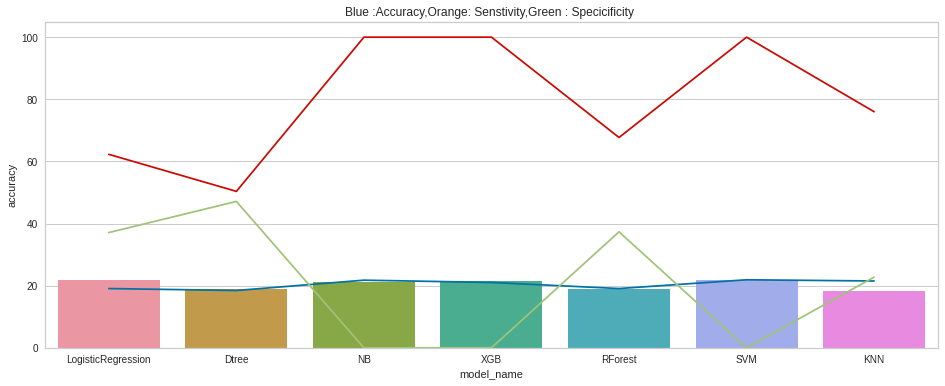

In [68]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

# **Conclusion**

I have modeled party affiliation factor to check the fakeness of news or statement between 1-6 and the logistic regression model is giving a highest accuracy of approx 22% in case of multiclass classification. Whereas it was giving 56% in case of binary classification during iteration 1.


# **References**



1.   [Genism Doc2Vec](https://https://www.programcreek.com/python/example/103013/gensim.models.doc2vec.TaggedDocument)
2.   [Deep learning and Embedding layers on tabular data](https://towardsdatascience.com/how-to-gain-state-of-the-art-result-on-tabular-data-with-deep-learning-and-embedding-layers-d1eb6b83c52c)
3.   [Building RNN Model](https://github.com/swethac18/AlternusVera/blob/master/factor_Party_Affliation/Party_Affliation_RNN_GENERATION2.ipynb)
